## Data:
- A short primer of underwriting in the credit industry -
- In general, whenever an individual/corporation applies for a loan from a bank (or any loan issuer), their credit history undergoes a rigorous check to ensure that whether they are capable enough to pay off the loan (in this industry it is referred to as credit-worthiness).
- The issuers have a set of model/s and rule/s in place which take information regarding their current financial standing, previous credit history and some other variables as input and output a metric which gives a measure of the risk that the issuer will potentially take on issuing the loan. The measure is generally in the form of a probability and is the risk that the person will default on their loan (called the probability of default) in the future.
- Based on the amount of risk that the issuer is willing to take (plus some other factors) they decide on a cutoff of that score and use it to take a decision regarding whether to pass the loan or not. This is a way of managing credit risk. The whole process collectively is referred to as underwriting.

#### Sources for credit risk business details

- http://budgeting.thenest.com/mean-loan-goes-underwriting-23201.html
- http://www.investopedia.com/ (a great source to find meanings of BFSI terminology and jargon)

In [64]:
import pandas as pd

data = pd.read_table("XYZCorp_LendingData.txt",parse_dates=['issue_d'])

/var/folders/1y/hs8w9lqd56df4lg10hxlx_dw0000gn/T/ipykernel_1007/15388508.py:3: DtypeWarning: Columns (17,45,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_table("XYZCorp_LendingData.txt",parse_dates=['issue_d'])
/var/folders/1y/hs8w9lqd56df4lg10hxlx_dw0000gn/T/ipykernel_1007/15388508.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_table("XYZCorp_LendingData.txt",parse_dates=['issue_d'])


In [65]:
data.shape

(855969, 73)

In [ ]:
data

### Preprocessor

In [4]:
print(data.columns)
event_rate = (data.default_ind.value_counts()[1]/data.shape[0])*100
print('\ncredit default rate: ',event_rate)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'acc_now_delinq', 'tot_col

In [5]:
#data is for 2015 so using 2015 to calculate total credit age
curr_year = 2015
data[['earliest_cr_month','earliest_cr_year']] = data['earliest_cr_line'].str.split('-',expand=True)
data['cr_age_years'] = data['earliest_cr_year'].apply(lambda x: curr_year - int(x))

# parse last credit pulled date and last payment dates into month/year - we will use this as nominal variables


# TODO: later convert to age and use last pulled credit age

data['last_credit_pull_d'] = pd.to_datetime(data['last_credit_pull_d'])
data['last_credit_pulled_month'] = data['last_credit_pull_d'].apply(lambda x: x.month + x.year*100)


data['last_pymnt_d'] = pd.to_datetime(data['last_pymnt_d'])
data['last_payment_month'] = data['last_pymnt_d'].apply(lambda x: x.month + x.year*100)


data['issue_d'] = pd.to_datetime(data['issue_d'])
data['issue_month'] = data['issue_d'].apply(lambda x: x.month + x.year*100)


#replacing values in emp_length - convert categorical to numeric data
replacement_dict ={
'10+ years': 10,
'2 years': 2,
'< 1 year': 0.5,
'3 years':3,
'1 year':1,
'5 years':5,
'4 years':4,
'7 years':7,
'8 years':8,
'6 years':6,
'9 years':9
}

data['emp_length'] =  data['emp_length'].replace(replacement_dict)

/var/folders/1y/hs8w9lqd56df4lg10hxlx_dw0000gn/T/ipykernel_1007/1262131824.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['last_credit_pull_d'] = pd.to_datetime(data['last_credit_pull_d'])
/var/folders/1y/hs8w9lqd56df4lg10hxlx_dw0000gn/T/ipykernel_1007/1262131824.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['last_pymnt_d'] = pd.to_datetime(data['last_pymnt_d'])


In [6]:
def get_missing_cols(data):
    n = data.shape[0]
    missing_cols = {}
    for col in data.columns:
        data_description = data[col].describe()
        count = data_description[0]
        missing_percent = 100*(n - count)/n
        if missing_percent>0:
            missing_cols[col] = missing_percent
    return missing_cols

In [7]:
# cr_age_bins = [0,18,24,34,40,100]
# data['cr_age_binned'] = pd.cut(data['cr_age_years'],cr_age_bins)
# age_binned_defaulters = data.cr_age_binned.value_counts().reset_index()

# defaulters = data[data['default_ind']==1]
# age_binned_defaulters['defaulters'] = defaulters.cr_age_binned.value_counts().reset_index()['count']
# age_binned_defaulters['percentage'] = age_binned_defaulters.apply(lambda x: x['defaulters']*100/x['count'], axis=1)


In [8]:
# Drop unnecessary columns

cols_missing_val = get_missing_cols(data)
threshold = 25  #Removing columns with more than 25% missing values
missing_cols = [col for col in cols_missing_val if cols_missing_val[col] >= threshold]
cols_identifiers = ['member_id','id','emp_title']
linearly_related_cols = ['zip_code', 'earliest_cr_line', 'earliest_cr_month', 'earliest_cr_year','loan_amnt','funded_amnt_inv','last_pymnt_d','last_credit_pull_d']
other_removables = ['desc', 'policy_code', 'title','out_prncp','total_pymnt']

# TODO: Check after removing title also

to_drop = missing_cols+cols_identifiers+linearly_related_cols+other_removables
to_impute = [col for col in cols_missing_val if cols_missing_val[col]<threshold and col not in to_drop]

In [9]:
data = data.drop(columns=to_drop)

In [10]:
#TODO: build imputation strategies (change immputation strategy based on the column interpretation)

# imputing all columns with mode for now
def imputer(data,cols_to_impute,strategy):
    if strategy == 'mode':
        for col in cols_to_impute:
            data[col] = data[col].fillna(data[col].mode()[0])
    elif strategy == 'mean':
        for col in cols_to_impute:
            data[col] = data[col].fillna(data[col].mean())

imputer(data,cols_to_impute=to_impute,strategy='mode')

In [11]:
def normalizer(data,cols,norm):
    for col in cols:
        normalized_col = col & '_normalized'
        data[normalized_col] = data[col]/data[norm]
    data.drop(columns = cols)

In [12]:
# Normalize 'tot_cur_bal', 'total_rev_hi_lim', 'total_rec_prncp', 'total_rec_int', 'annual_inc', 'revol_bal'  using loan amount
cols_to_norm_totamt = ['tot_cur_bal', 'total_rev_hi_lim', 'total_rec_prncp', 'total_rec_int','annual_inc', 'revol_bal']
normalizer(data,cols_to_norm_totamt,'funded_amnt')


# Normalize 'tot_coll_amt','total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt' fees with installment amount

cols_to_norm_instamt = ['tot_coll_amt','total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt']
normalizer(data,cols_to_norm_instamt,'installment')

### EDA

- We can plot and study coherances/correlations in the data now

In [13]:
non_object_cols = data.select_dtypes(exclude=['object'])
non_object_cols

,funded_amnt,int_rate,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,inq_last_6mths,open_acc,...,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default_ind,cr_age_years,last_credit_pulled_month,last_payment_month,issue_month
0,5000.0,10.65,162.87,10.0,4.800000,2011-12-01,27.65,0.0,1.0,3.0,...,0.0,0.0,0.0,0.000000,3.000000,0,30,201601.0,201501.0,201112
1,2500.0,15.27,59.83,0.5,12.000000,2011-12-01,1.00,0.0,5.0,3.0,...,0.0,0.0,0.0,0.000000,6.000000,1,16,201309.0,201304.0,201112
2,2400.0,15.96,84.33,10.0,5.105000,2011-12-01,8.72,0.0,2.0,2.0,...,0.0,0.0,0.0,0.000000,6.250000,0,14,201601.0,201406.0,201112
3,10000.0,13.49,339.31,10.0,4.920000,2011-12-01,20.00,0.0,1.0,10.0,...,0.0,0.0,0.0,0.000000,1.500000,0,19,201501.0,201501.0,201112
4,3000.0,12.69,67.79,1.0,26.666667,2011-12-01,17.94,0.0,0.0,15.0,...,0.0,0.0,0.0,0.000000,5.000000,0,19,201601.0,201601.0,201112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855964,10000.0,11.99,332.10,8.0,3.100000,2015-01-01,28.69,0.0,0.0,9.0,...,0.0,0.0,0.0,2.527400,1.710000,0,11,201601.0,201601.0,201501
855965,24000.0,11.99,797.03,10.0,3.291667,2015-01-01,3.90,0.0,1.0,5.0,...,0.0,0.0,0.0,5.845208,0.425000,0,41,201601.0,201601.0,201501
855966,13000.0,15.99,316.07,5.0,2.692308,2015-01-01,30.90,0.0,0.0,9.0,...,0.0,0.0,0.0,2.629077,1.384615,0,12,201601.0,201601.0,201501
855967,12000.0,19.99,317.86,1.0,5.366667,2015-01-01,27.19,1.0,2.0,17.0,...,1.0,0.0,0.0,4.868167,2.250000,0,12,201601.0,201601.0,201501


In [14]:
object_cols = data.select_dtypes(include=['object'])
categorical_cols = list(object_cols.columns) + ['default_ind']

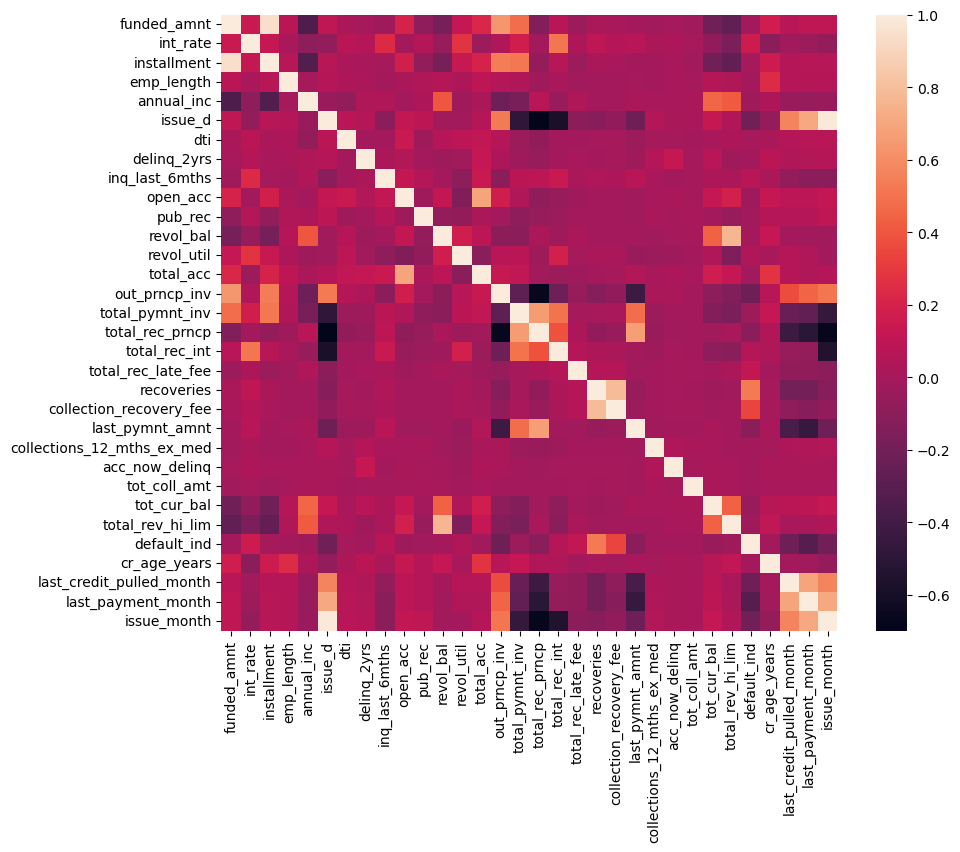

In [15]:
#correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns
corrmat = non_object_cols.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrmat, vmax=1, square=True);

In [16]:
correlation_with_result = corrmat['default_ind'].reset_index()

In [17]:
correlation_with_result = correlation_with_result[correlation_with_result['index'] != 'default_ind']

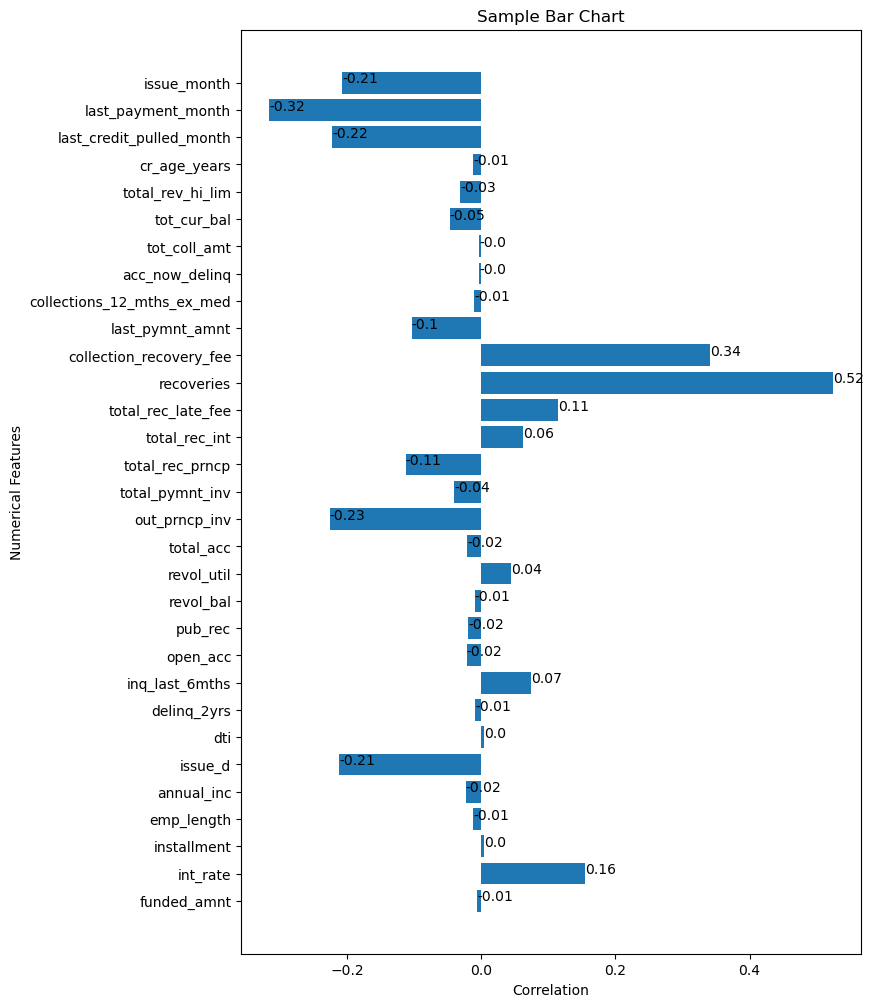

In [18]:
import matplotlib.pyplot as plt

# Create bar chart
categories = correlation_with_result['index']
values = correlation_with_result['default_ind']
plt.figure(figsize=(8, 12))

plt.barh(categories, values)
# Adding labels and title
plt.xlabel('Correlation')
plt.ylabel('Numerical Features')
plt.title('Sample Bar Chart')


# Adding data labels
for index, value in enumerate(values):
    plt.text(value, index, str(round(value,2)))
# Show the plot
plt.show()

<AxesSubplot:xlabel='default_ind', ylabel='int_rate'>

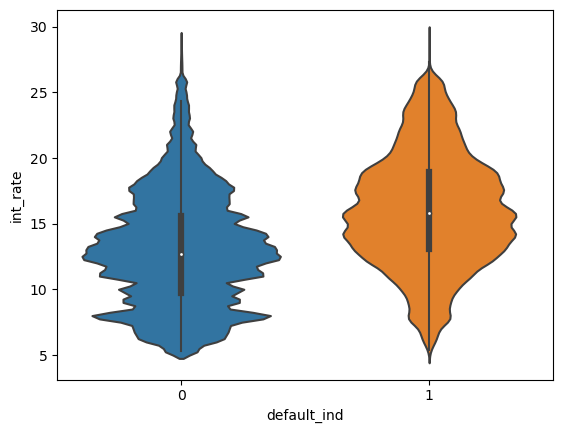

In [19]:
sns.violinplot(x = 'default_ind',y = 'int_rate',data=data,bw='scott')

array([[<AxesSubplot:title={'center':'funded_amnt'}>,
        <AxesSubplot:title={'center':'int_rate'}>,
        <AxesSubplot:title={'center':'installment'}>,
        <AxesSubplot:title={'center':'emp_length'}>,
        <AxesSubplot:title={'center':'annual_inc'}>,
        <AxesSubplot:title={'center':'issue_d'}>],
       [<AxesSubplot:title={'center':'dti'}>,
        <AxesSubplot:title={'center':'delinq_2yrs'}>,
        <AxesSubplot:title={'center':'inq_last_6mths'}>,
        <AxesSubplot:title={'center':'open_acc'}>,
        <AxesSubplot:title={'center':'pub_rec'}>,
        <AxesSubplot:title={'center':'revol_bal'}>],
       [<AxesSubplot:title={'center':'revol_util'}>,
        <AxesSubplot:title={'center':'total_acc'}>,
        <AxesSubplot:title={'center':'out_prncp_inv'}>,
        <AxesSubplot:title={'center':'total_pymnt_inv'}>,
        <AxesSubplot:title={'center':'total_rec_prncp'}>,
        <AxesSubplot:title={'center':'total_rec_int'}>],
       [<AxesSubplot:title={'center':'t

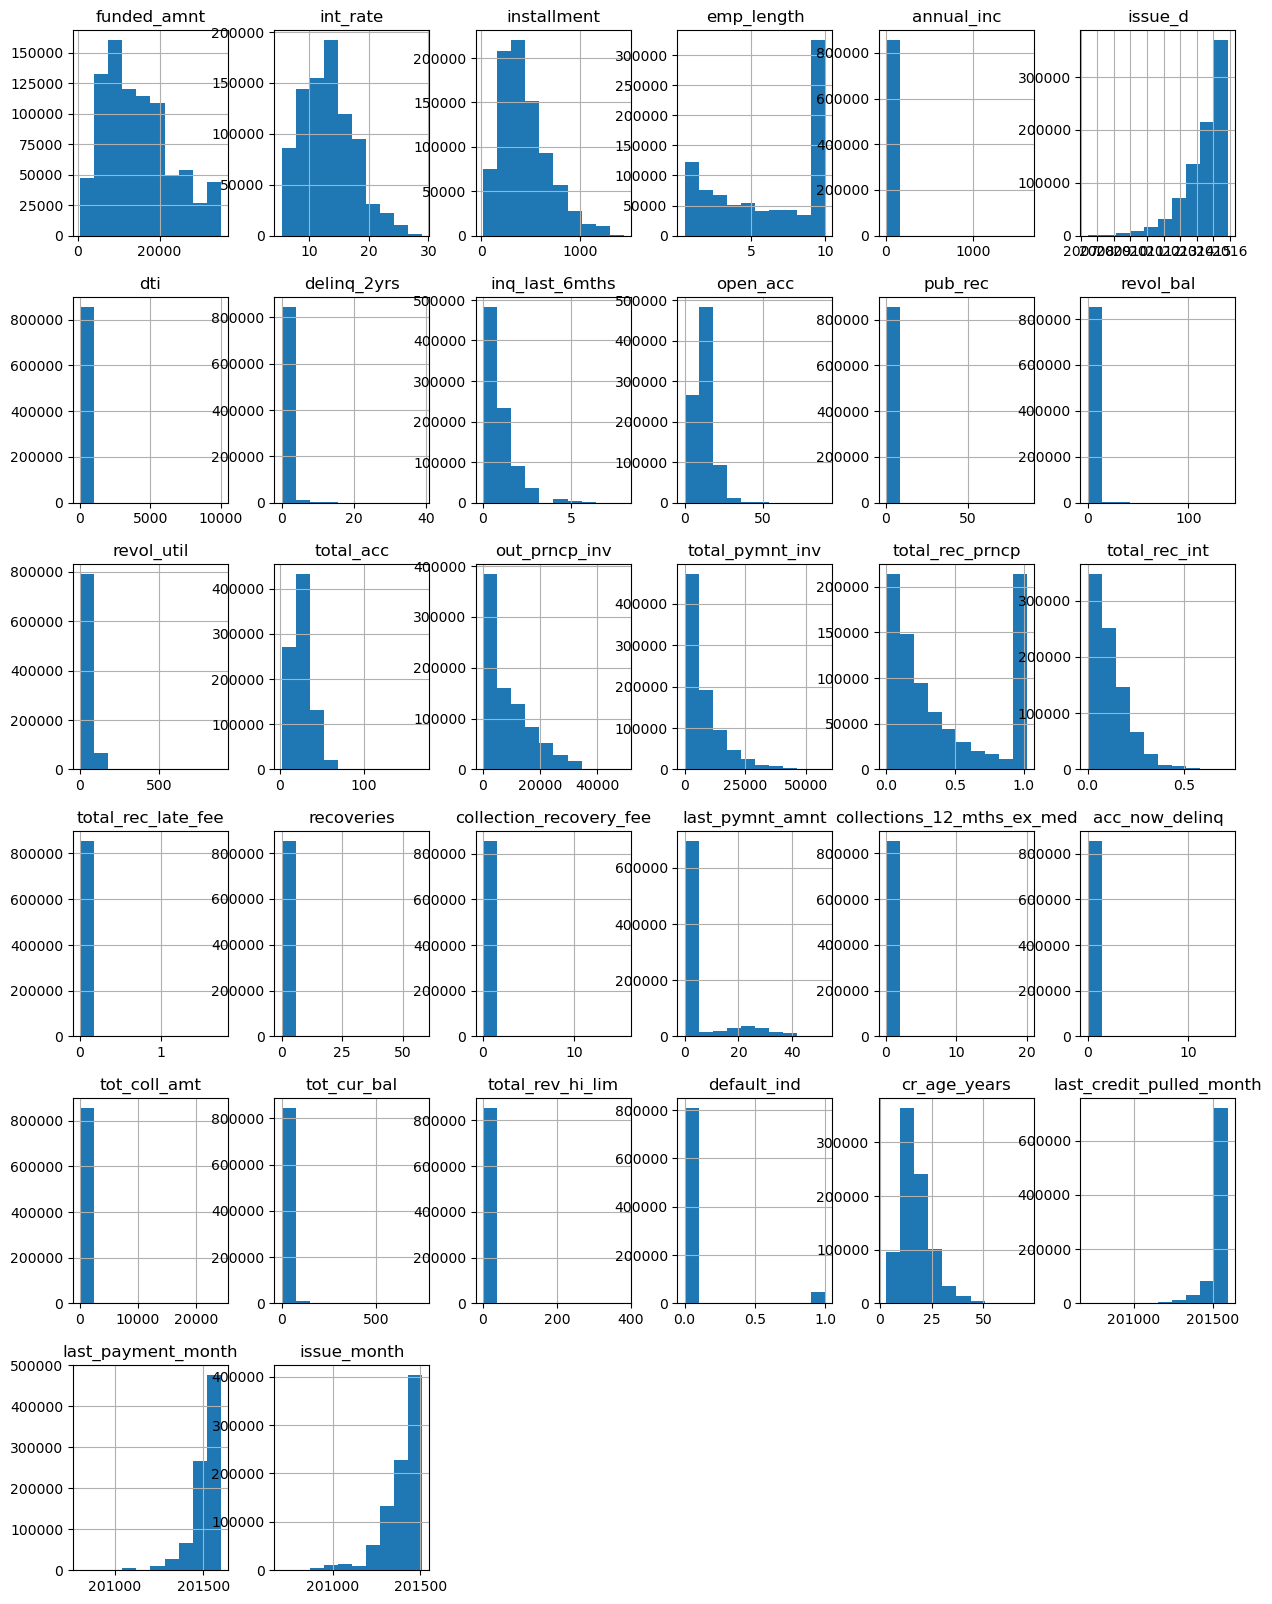

In [20]:
non_object_cols.hist(figsize=(15,20))

In [21]:
object_cols

from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Example usage:
# Suppose we have two categorical variables x and y

cramers_v_dict = {}
for col in categorical_cols:
    if col != 'default_ind':
        x = data[col]
        y = data['default_ind']
        cramers_v_dict[col] = cramers_v(x, y)*100

cramersv_df = pd.DataFrame.from_dict(cramers_v_dict, orient='index').reset_index()
cramersv_df.columns = ['feature_name','CramersV']

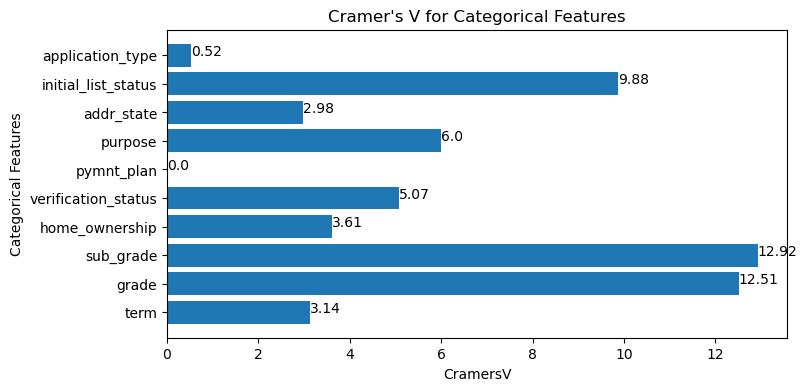

In [351]:
cramersv_df
# Create bar chart
categories = cramersv_df['feature_name']
values = cramersv_df['CramersV']
plt.figure(figsize=(8,4))

plt.barh(categories, values)
# Adding labels and title
plt.xlabel('CramersV')
plt.ylabel('Categorical Features')
plt.title("Cramer's V for Categorical Features")


# Adding data labels
for index, value in enumerate(values):
    plt.text(value, index, str(round(value,2)))
# Show the plot
plt.show()

In [22]:
def plot_pivot(col):
    category = col
    pivot = pd.pivot_table(
            data,
            index=category,
            columns=['default_ind'],
            aggfunc='size'
        ).reset_index()
    pivot['event_rate'] = pivot.apply(lambda x: x[1]*100/(x[0]+x[1]), axis=1)
    # print(pivot[col].nunique())
    fig_size_y = (18/50)*(pivot[col].nunique())
    fig_size_x = 4

    plt.figure(figsize=(fig_size_x,fig_size_y))
    plt.barh(pivot[col], pivot['event_rate'])
    plt.axvline(x=event_rate, color='#FFA500', linestyle='--', label = 'overall event rate')
    
    # Adding labels and title
    plt.xlabel('Event Rate (%)')
    plt.ylabel(col)
    plt.title("Event Rate for {}".format(col))


    # Adding data labels
    for index, value in enumerate(pivot['event_rate']):
        plt.text(value, index, str(round(value,2) & ' %'))
    # Show the plot
    plt.show()

cant plot  term
cant plot  grade
cant plot  sub_grade
cant plot  home_ownership
cant plot  verification_status
cant plot  pymnt_plan
cant plot  purpose
cant plot  addr_state
cant plot  initial_list_status
cant plot  application_type


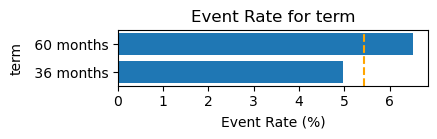

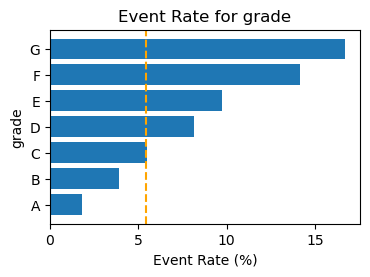

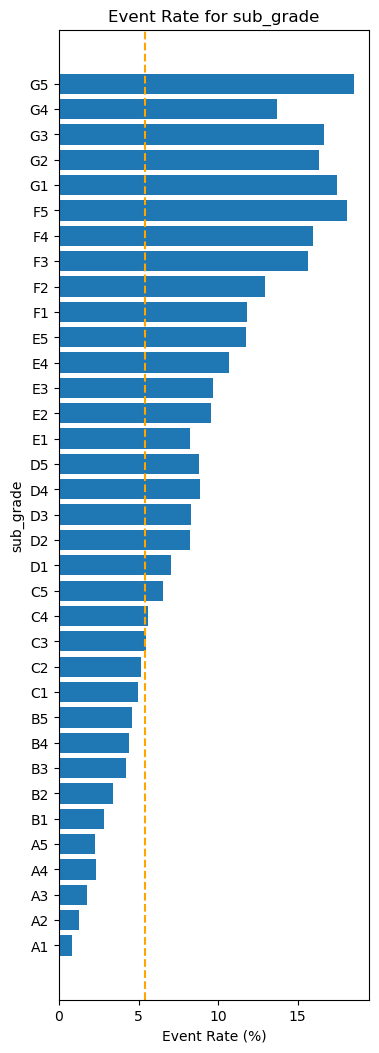

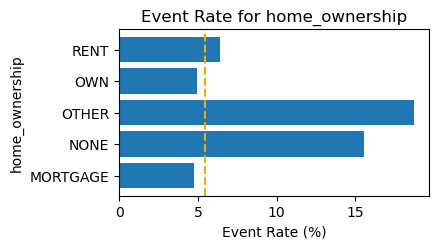

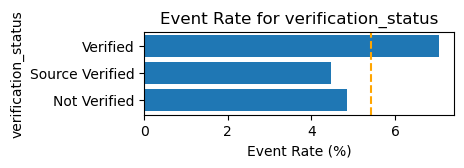

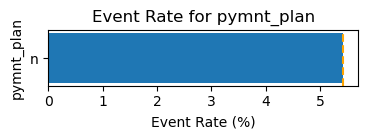

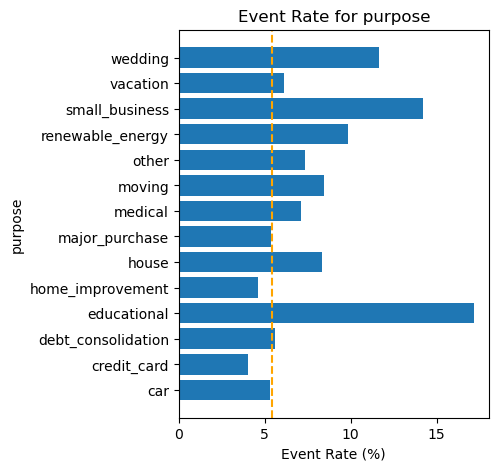

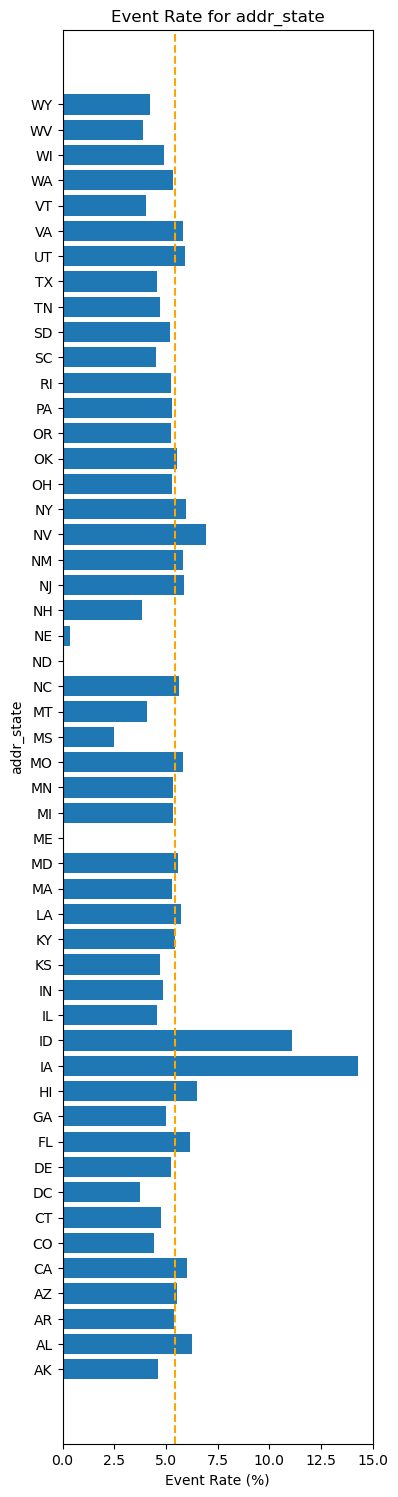

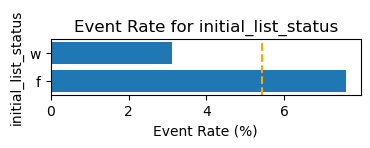

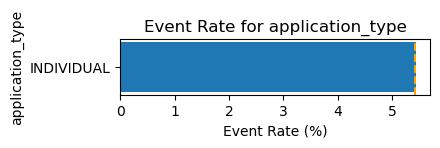

In [23]:
for col in categorical_cols:
    if col != 'default_ind':
        try:
            plot_pivot(col)
        except:
            print('cant plot ', col)

### Encoding

- Imputed, Normalized & Cleaned data is now ready to be encoded

In [24]:
numerical_columns = non_object_cols.columns

In [25]:
numerical_columns

Index(['funded_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'issue_d', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp_inv',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'default_ind',
       'cr_age_years', 'last_credit_pulled_month', 'last_payment_month',
       'issue_month'],
      dtype='object')

In [26]:
categorical_cols

['term',
 'grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type',
 'default_ind']

##### There are no Ordinal Features
- Encoding other columns accordingly

In [27]:
data = data.reset_index()

In [28]:
# Splitting dataset
target_col = 'default_ind'
to_remove = [target_col,'issue_d']
features = [col for col in data.columns if col not in to_remove]
y = data[target_col]
X = data[features]

In [29]:
from sklearn.model_selection import train_test_split, cross_validate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [30]:
categorical_cols = [col for col in categorical_cols if col !='default_ind']

In [31]:
X_train.columns

Index(['index', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp_inv',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'cr_age_years', 'last_credit_pulled_month', 'last_payment_month',
       'issue_month'],
      dtype='object')

In [32]:
categorical_cols = [col for col in categorical_cols if col in X.columns]

In [33]:
categorical_cols = [col for col in categorical_cols if col in X.columns]
categorical_cols

['term',
 'grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type']

In [34]:
numerical_columns

Index(['funded_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'issue_d', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp_inv',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'default_ind',
       'cr_age_years', 'last_credit_pulled_month', 'last_payment_month',
       'issue_month'],
      dtype='object')

In [35]:
numerical_columns = [col for col in numerical_columns if col in X.columns]
numerical_columns

['funded_amnt',
 'int_rate',
 'installment',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp_inv',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'cr_age_years',
 'last_credit_pulled_month',
 'last_payment_month',
 'issue_month']

In [36]:
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, MinMaxScaler, PowerTransformer, KBinsDiscretizer, StandardScaler
from sklearn.compose import ColumnTransformer
import scipy
nominal_pipeline = make_pipeline(OneHotEncoder(drop='first', handle_unknown = 'ignore'))
# numeric_pipeline = make_pipeline(PowerTransformer('yeo-johnson'), MinMaxScaler())
numeric_pipeline = make_pipeline(MinMaxScaler(),PowerTransformer('yeo-johnson'))
# num_trans = Pipeline(steps=[
#             ('imputer', SimpleImputer(strategy='median')),
#             ('scaler', StandardScaler())])  
# cat_trans = OneHotEncoder(handle_unknown='ignore')
preprocessing_pipeline = ColumnTransformer(transformers=[
    ('nominal_pipeline',nominal_pipeline,categorical_cols),
    ('numeric_pipeline',numeric_pipeline,numerical_columns)
])

In [37]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [39]:

# #First checking baseline models for accuracy comparision and then we will tune hyperparameters later

# models= {
#     'DT': DecisionTreeClassifier(random_state=42)
#     # 'RF':RandomForestClassifier(random_state=201),
#     # 'XGB': XGBClassifier(),
#     # 'KNN':KNeighborsClassifier()
#     # ,
#     # 'CatBoost': CatBoostClassifier(verbose=0, random_seed=201)
#     }
result = []

In [40]:
from sklearn.metrics import confusion_matrix

In [41]:
def plot_cf(pipeline,X_test,y_test):
    predictions = pipeline.predict(X_test)
    cm = confusion_matrix(y_test, predictions)

    # Visualize confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [42]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Compute precision-recall curve
def model_scores(pipeline,X_test,y_test):
    predictions = pipeline.predict(X_test)
    model_report = classification_report(y_test, predictions)
    print(model_report)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    precision, recall, threshold = precision_recall_curve(y_test, y_prob)

    ap = average_precision_score(y_test, y_prob)
    pr_auc = auc(recall, precision)
    
    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.2f}, AP = {ap:.2f})', color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [43]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test are the true labels and y_score are the predicted probabilities
# Calculate ROC curve

def plot_roc(pipeline,X_test,y_test):
    predictions = pipeline.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, predictions)

    # Calculate area under the curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [44]:
# Get predicted probabilities on the test set

def plot_gain_lift(pipeline,X_test,y_test):
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Calculate gain and lift values
    def calculate_gain_lift(y_test, y_prob, num_buckets=10):
        order = np.argsort(y_prob)[::-1]
        y_test_sorted = y_test[order]
        y_prob_sorted = y_prob[order]
        total_positives = np.sum(y_test)
        
        gains = []
        lifts = []
        for i in range(1, num_buckets + 1):
            bucket_size = int(len(y_prob) * i / num_buckets)
            bucket_true = y_test_sorted[:bucket_size]
            bucket_positives = np.sum(bucket_true)
            gains.append(bucket_positives / total_positives)
            lifts.append(bucket_positives / (total_positives * (bucket_size / len(y_prob))))
            
        return gains, lifts

    gains, lifts = calculate_gain_lift(np.array(y_test), y_prob)

    # Plot the gain and lift charts
    num_instances = range(1, len(gains) + 1)

    plt.figure(figsize=(12, 5))

    # Gain Chart
    plt.subplot(1, 2, 1)
    plt.plot(num_instances, gains, marker='o')
    plt.title('Gain Chart')
    plt.xlabel('Number of Instances')
    plt.ylabel('Cumulative Gain')

    # Lift Chart
    plt.subplot(1, 2, 2)
    plt.plot(num_instances, lifts, marker='o')
    plt.title('Lift Chart')
    plt.xlabel('Number of Instances')
    plt.ylabel('Lift')

    plt.tight_layout()
    plt.show()

In [45]:
def model_eval_report(pipeline,X_test,y_test, name, cv):
    print ("Evaluation of {} model".format(name))
    print(pd.DataFrame(cv))
    plot_roc(pipeline,X_test,y_test)
    model_scores(pipeline,X_test,y_test)
    plot_cf(pipeline,X_test,y_test)
    plot_gain_lift(pipeline,X_test,y_test)

In [46]:
model =  RandomForestClassifier(n_estimators= 10, min_samples_leaf = 100,random_state=201)
name = 'RF model'

final_pipeline = make_pipeline(preprocessing_pipeline,model)
final_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['term', 'grade', 'sub_grade',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'pymnt_plan', 'purpose',
                                                   'addr_state',
                                                   'initial_list_status',
                                                   'application_type']),
                                                 ('numeric_pipeline',
                                                  Pipelin...
                                                   'total_rec_late_fee',
                                                   'recoveries',
                                                   'collection_recovery_fee',
                                                   'last_pymnt_amnt',
                                                   'collections_12_mths_ex_med',
                                                   'acc_now_delinq',
                                                   'tot_coll_amt',
                                                   'tot_cur_bal',
                                                   'total_rev_hi_lim',
                                                   'cr_age_years',
                                                   'last_credit_pulled_month',
                                                   'last_payment_month',
                                                   'issue_month'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_leaf=100, n_estimators=10,
                                        random_state=201))])

In [47]:
cv = cross_validate(final_pipeline,X_train,y_train, cv = 5, return_train_score=True, scoring='roc_auc')

/Users/sudhanshuranjan/miniforge3/envs/envNew/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [48]:
from imblearn.under_sampling import RandomUnderSampler

# Undersample the majority class
sampler = RandomUnderSampler(random_state=42)
X_res_train, y_res_train = sampler.fit_resample(X_train, y_train)


In [49]:
X_res_test, y_res_test = sampler.fit_resample(X_test, y_test)

In [50]:
final_pipeline.fit(X_res_train,y_res_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['term', 'grade', 'sub_grade',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'pymnt_plan', 'purpose',
                                                   'addr_state',
                                                   'initial_list_status',
                                                   'application_type']),
                                                 ('numeric_pipeline',
                                                  Pipelin...
                                                   'total_rec_late_fee',
                                                   'recoveries',
                                                   'collection_recovery_fee',
                                                   'last_pymnt_amnt',
                                                   'collections_12_mths_ex_med',
                                                   'acc_now_delinq',
                                                   'tot_coll_amt',
                                                   'tot_cur_bal',
                                                   'total_rev_hi_lim',
                                                   'cr_age_years',
                                                   'last_credit_pulled_month',
                                                   'last_payment_month',
                                                   'issue_month'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_leaf=100, n_estimators=10,
                                        random_state=201))])

Evaluation of RF model model
    fit_time  score_time  test_score  train_score
0  11.455510    0.318820    0.999980     0.999950
1  12.010643    0.319164    0.999876     0.999915
2  12.177913    0.311354    0.999861     0.999937
3  11.115688    0.305588    0.999880     0.999917
4  12.281632    0.321830    0.999558     0.999650


/Users/sudhanshuranjan/miniforge3/envs/envNew/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


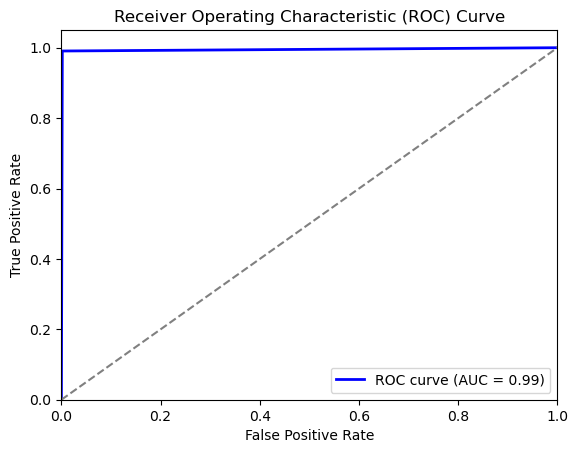

/Users/sudhanshuranjan/miniforge3/envs/envNew/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    404775
           1       0.97      0.99      0.98     23210

    accuracy                           1.00    427985
   macro avg       0.98      0.99      0.99    427985
weighted avg       1.00      1.00      1.00    427985



/Users/sudhanshuranjan/miniforge3/envs/envNew/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


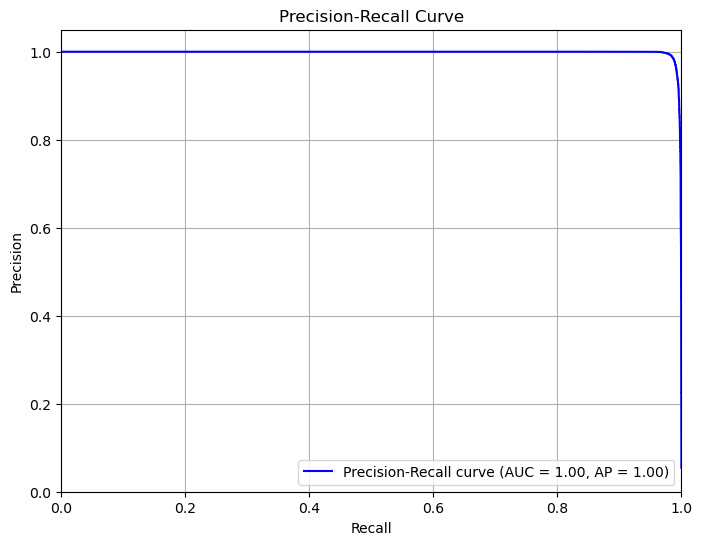

/Users/sudhanshuranjan/miniforge3/envs/envNew/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


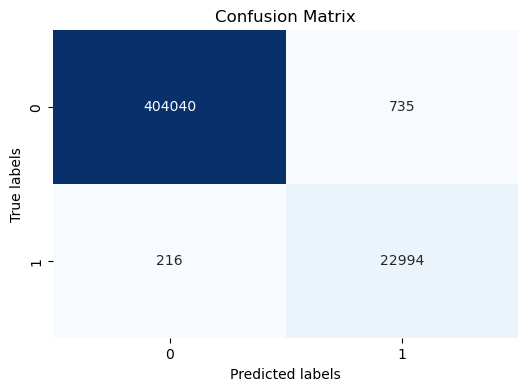

/Users/sudhanshuranjan/miniforge3/envs/envNew/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


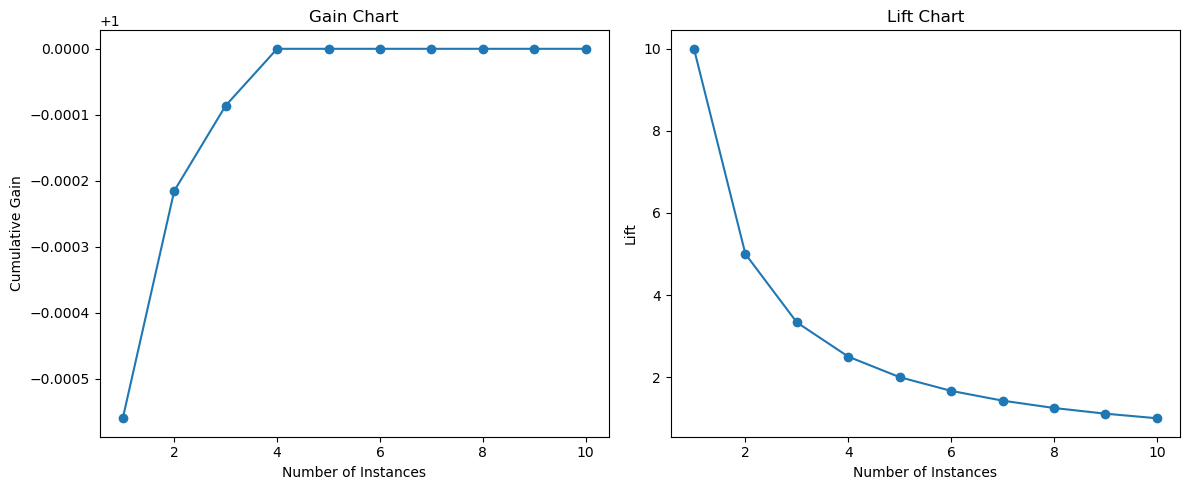

In [51]:
# from model_eval import model_eval_report
model_eval_report(final_pipeline,X_test,y_test, name, cv)

In [53]:
model = final_pipeline.named_steps['randomforestclassifier']
values = model.feature_importances_
values = np.array(values)*100
# print(final_pipeline)

In [54]:
onehot_feature_names = final_pipeline.named_steps['columntransformer'].named_transformers_['nominal_pipeline'].named_steps['onehotencoder'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_columns + onehot_feature_names.tolist()
len(all_feature_names)

141

In [55]:
len(values)

141

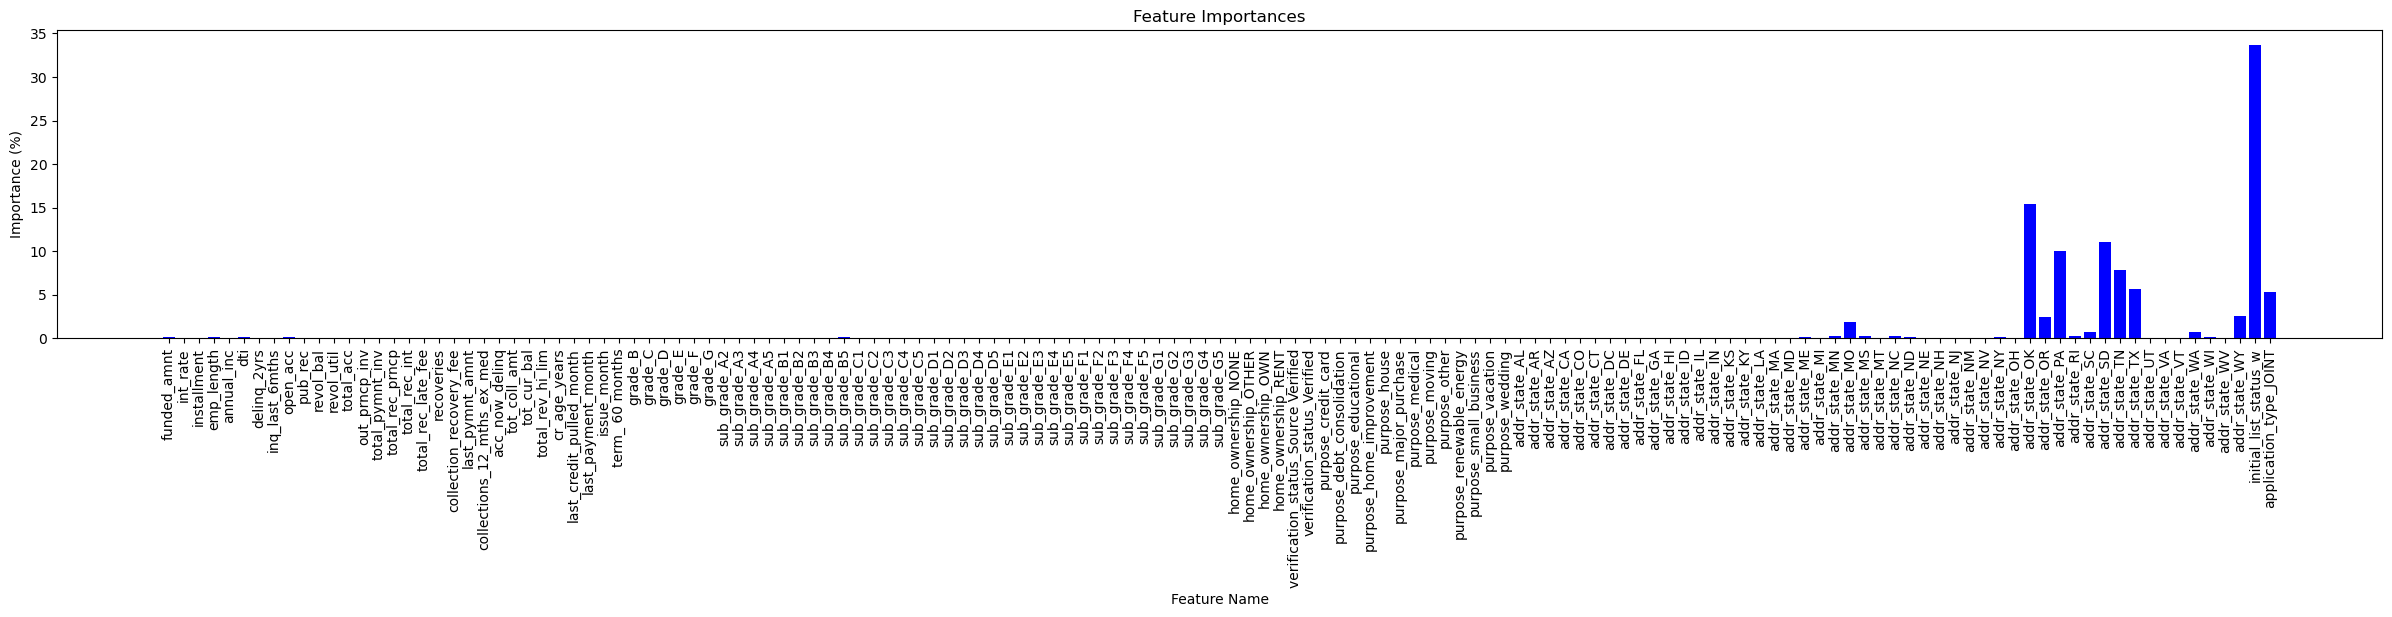

In [62]:
# Plot the bar chart
plt.figure(figsize=(30, 4))
plt.bar(all_feature_names, values, color='b', align='center')

# Label the axes
plt.xlabel('Feature Name')
plt.ylabel('Importance (%)')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.show()


Evaluation of RF model model
    fit_time  score_time  test_score  train_score
0  11.455510    0.318820    0.999980     0.999950
1  12.010643    0.319164    0.999876     0.999915
2  12.177913    0.311354    0.999861     0.999937
3  11.115688    0.305588    0.999880     0.999917
4  12.281632    0.321830    0.999558     0.999650


/Users/sudhanshuranjan/miniforge3/envs/envNew/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


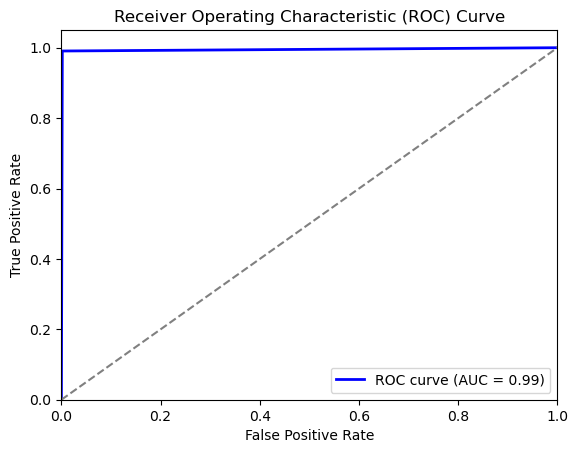

/Users/sudhanshuranjan/miniforge3/envs/envNew/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    404775
           1       0.97      0.99      0.98     23210

    accuracy                           1.00    427985
   macro avg       0.98      0.99      0.99    427985
weighted avg       1.00      1.00      1.00    427985



/Users/sudhanshuranjan/miniforge3/envs/envNew/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


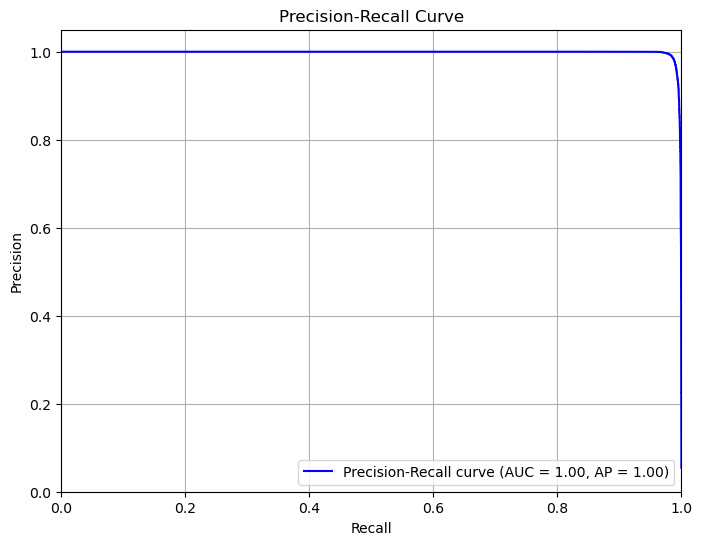

/Users/sudhanshuranjan/miniforge3/envs/envNew/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


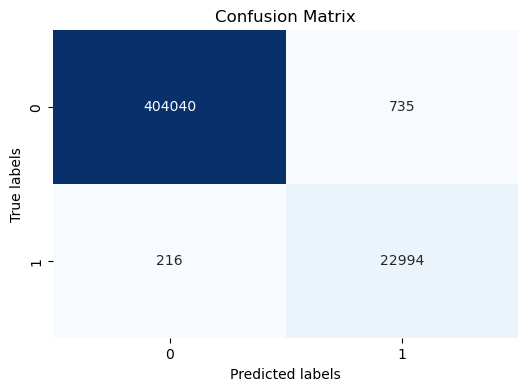

/Users/sudhanshuranjan/miniforge3/envs/envNew/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


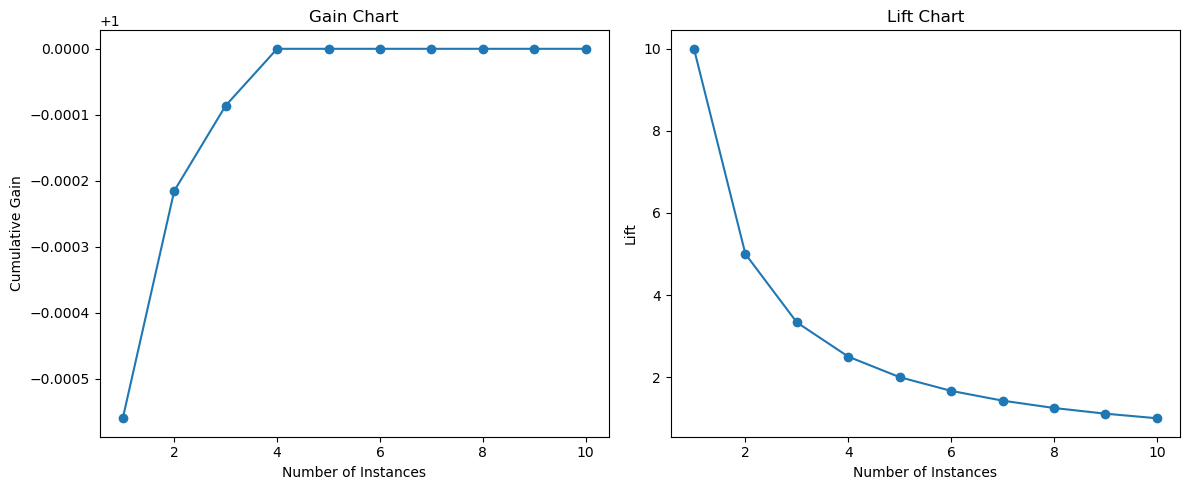

In [63]:
from model_eval import model_eval_report
model_eval_report(final_pipeline,X_test,y_test, name, cv)